# Optimisation meilleur modèle

In [ ]:
# Imports

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    StratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    make_scorer,
    roc_curve,
    roc_auc_score,
)
from scipy.stats import randint, uniform, loguniform
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
# Chemins

PROJECT_DIR = Path().cwd().parent.resolve()
DATA_DIR = PROJECT_DIR / "data"
DATA_PATH = DATA_DIR / "03_DONNEES.csv"
OUTPUT_DIR = PROJECT_DIR / "output"
MODELS_DIR = OUTPUT_DIR / "models"
BEST_MODEL_PATH = MODELS_DIR / "logistic_regression.pkl"
FIGURES_DIR = OUTPUT_DIR / "figures"
METRICS_DIR = OUTPUT_DIR / "metrics"

In [103]:
# Accessibilité : Daltonisme, Dyslexie, Confort Visuel

sns.set_theme(
    style="whitegrid",
    palette="colorblind",
    context="notebook",
)

plt.rcParams.update(
    {
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "font.family": "Arial",
        "font.size": 12,
        "axes.titlesize": 15,
        "axes.titleweight": "bold",
        "axes.labelsize": 13,
        "axes.labelweight": "medium",
        "axes.edgecolor": "black",
        "axes.linewidth": 1.2,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "lines.linewidth": 2.2,
        "lines.markersize": 7,
        "legend.fontsize": 11,
        "legend.frameon": True,
        "legend.framealpha": 0.95,
        "grid.linestyle": ":",
        "grid.linewidth": 0.8,
        "grid.alpha": 0.6,
    }
)

COLORBLIND_PALETTE = sns.color_palette("colorblind")

## Chargement des données et du modèle

In [104]:
df = pd.read_csv(DATA_PATH.as_posix())

X = df.drop("Churn", axis=1)
y = df["Churn"].copy()

best_model = joblib.load(BEST_MODEL_PATH.as_posix())

## Split train / test

In [105]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True,
)

## Définition des paramètres de d'optimisation

In [106]:
param_distributions = {
    "classifier__C": loguniform(1e-1, 1e2),
    "classifier__l1_ratio": [
        0,
        # 0.5,
        # 1,
    ],
    "classifier__solver": [
        "lbfgs",
        "liblinear",
        "newton-cg",
        "newton-cholesky",
        "sag",
        "saga",
    ],
    # "classifier__class_weight": [None, "balanced"],
    # "classifier__dual": [True, False],
    "classifier__fit_intercept": [True, False],
}

scoring = make_scorer(f1_score, pos_label="Yes")

random_search = RandomizedSearchCV(
    best_model,
    param_distributions=param_distributions,
    n_iter=100,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring,
    random_state=42,
    n_jobs=-1,
    return_train_score=True,
)

random_search.fit(X_train, y_train)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'classifier__C': <scipy.stats....001FE69CA0C00>, 'classifier__fit_intercept': [True, False], 'classifier__l1_ratio': [0], 'classifier__solver': ['lbfgs', 'liblinear', ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",100
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",make_scorer(f...pos_label=Yes)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` f

In [107]:
print("Meilleurs paramètres :")
for name, value in random_search.best_params_.items():
    print(f"  {name} : {value}")

print("Meillieur score : ", random_search.best_score_)

Meilleurs paramètres :
  classifier__C : 0.115279871282324
  classifier__fit_intercept : False
  classifier__l1_ratio : 0
  classifier__solver : newton-cholesky
Meillieur score :  0.34384121653986


In [108]:
cv_results_random = pd.DataFrame(random_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results_random[
    [
        "param_classifier__C",
        "param_classifier__fit_intercept",
        # "param_classifier__l1_ratio",
        "param_classifier__solver",
        "mean_test_score",
        "std_test_score",
        "mean_train_score",
        "std_train_score",
        "rank_test_score",
    ]
].head()

,param_classifier__C,param_classifier__fit_intercept,param_classifier__solver,mean_test_score,std_test_score,mean_train_score,std_train_score,rank_test_score
4,0.115280,False,newton-cholesky,0.343841,0.005645,0.351131,0.001830,1
42,0.119195,True,newton-cg,0.343841,0.005343,0.351479,0.001970,2
43,0.124247,True,lbfgs,0.343731,0.005197,0.351236,0.002191,3
9,0.138037,False,saga,0.343730,0.005256,0.351291,0.001959,4
12,0.137832,True,sag,0.343730,0.005256,0.351319,0.001942,4


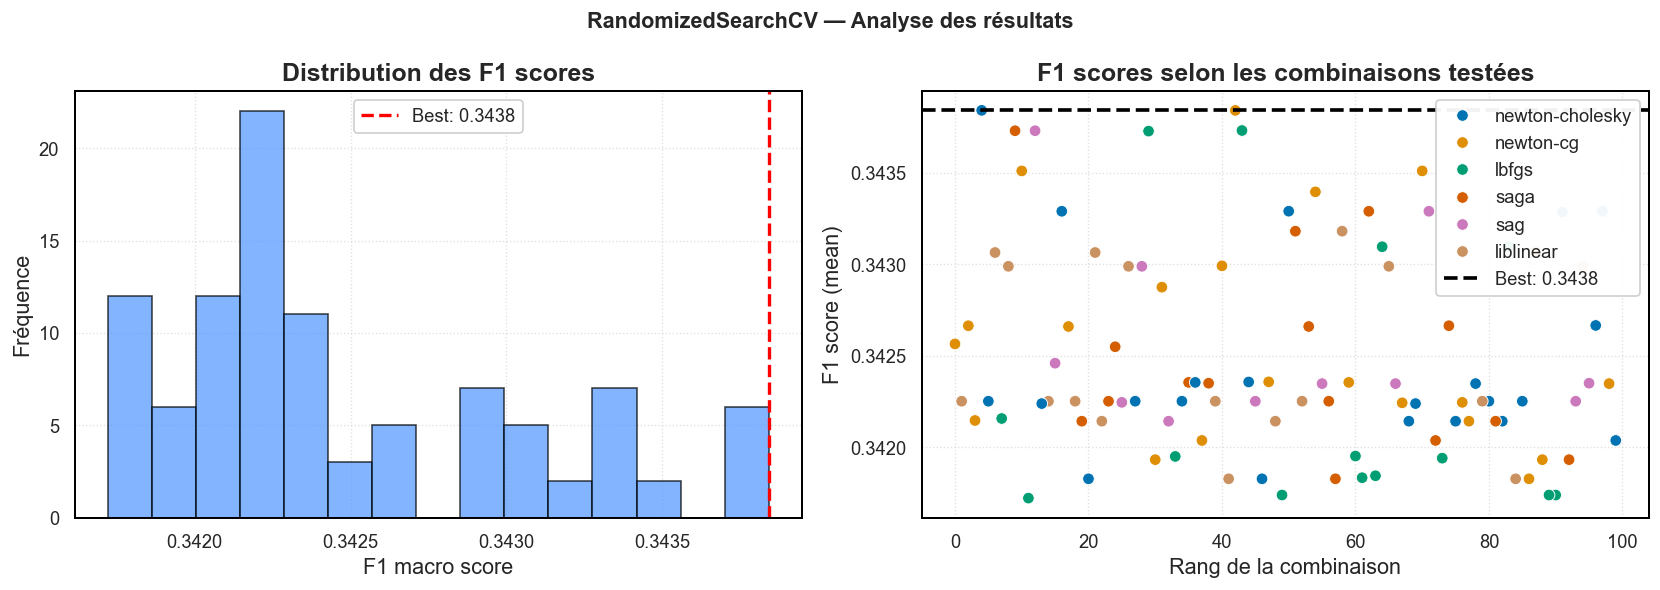

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(
    cv_results_random["mean_test_score"],
    bins=15,
    color="#4d94ff",
    alpha=0.7,
    edgecolor="black",
)
axes[0].axvline(
    random_search.best_score_,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Best: {random_search.best_score_:.4f}",
)
axes[0].set_xlabel("F1 macro score")
axes[0].set_ylabel("Fréquence")
axes[0].set_title("Distribution des F1 scores")
axes[0].legend()

ax1 = axes[1]
sns.scatterplot(
    x=cv_results_random.index,
    y=cv_results_random["mean_test_score"],
    hue=cv_results_random["param_classifier__solver"],
    ax=ax1,
)
ax1.axhline(
    random_search.best_score_,
    color="black",
    linestyle="--",
    label=f"Best: {random_search.best_score_:.4f}",
)
ax1.set_xlabel("Rang de la combinaison")
ax1.set_ylabel("F1 score (mean)")
ax1.set_title("F1 scores selon les combinaisons testées")
ax1.legend()

plt.suptitle(
    "RandomizedSearchCV — Analyse des résultats", fontsize=13, fontweight="bold"
)
plt.tight_layout()
plt.show()

In [110]:
best_model_optimize = random_search.best_estimator_

y_pred = best_model_optimize.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.91      0.64      0.75      1206
         Yes       0.22      0.63      0.33       203

    accuracy                           0.64      1409
   macro avg       0.57      0.63      0.54      1409
weighted avg       0.81      0.64      0.69      1409



In [111]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[768 438]
 [ 76 127]]


## Courbe d'apprentissage

In [112]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model_optimize,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring=scoring,
    n_jobs=-1,
    random_state=42,
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

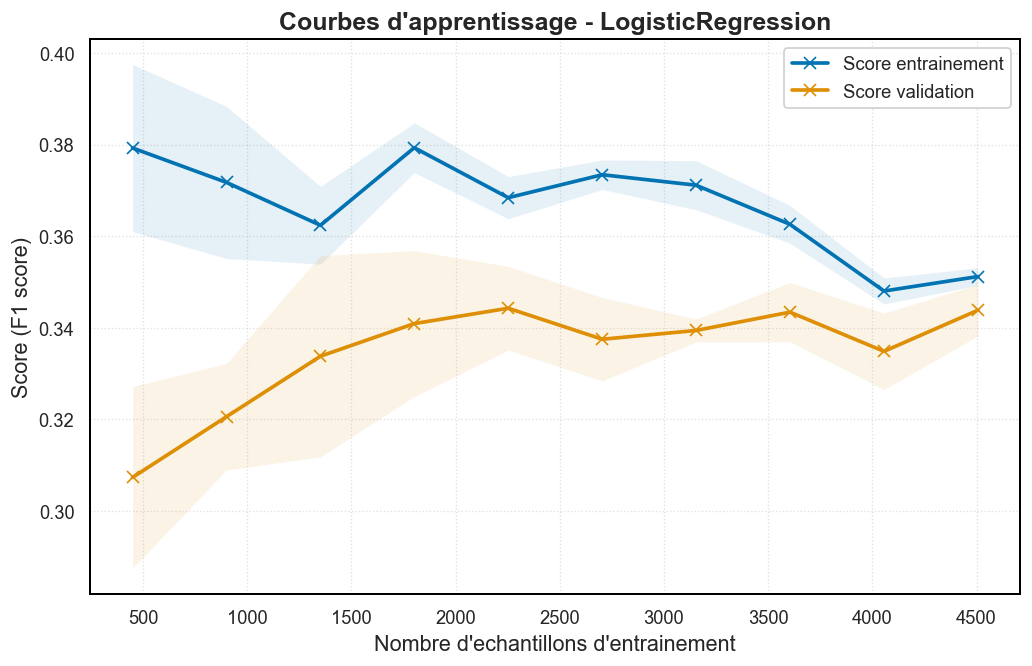

In [123]:
plt.figure(figsize=(10, 6))

plt.plot(
    train_sizes,
    train_mean,
    "x-",
    label="Score entrainement",
)
plt.plot(
    train_sizes,
    test_mean,
    "x-",
    label="Score validation",
)
plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.1,
)
plt.fill_between(
    train_sizes,
    test_mean - test_std,
    test_mean + test_std,
    alpha=0.1,
)
plt.xlabel("Nombre d'echantillons d'entrainement")
plt.ylabel("Score (F1 score)")
plt.title("Courbes d'apprentissage - LogisticRegression")
plt.legend()

plt.savefig((FIGURES_DIR / "04_learning_curve.png"))
plt.show()

Observation :
- Le modèle sous-apprend.

Conclusions :
- Tester un modèle plus complexe.
- Augmenter la taille du jeu de données.
- Ajouter des features (features engineering).

## Courbe ROC-AUC et seuil de Youden

In [115]:
y_proba = best_model_optimize.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label="Yes")
auc = roc_auc_score(y_test, y_proba)

print(f"AUC : {auc}")

AUC : 0.6834342246076678


In [116]:
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
print("Seuil optimal : ", optimal_threshold)

Seuil optimal :  0.46048103464394424


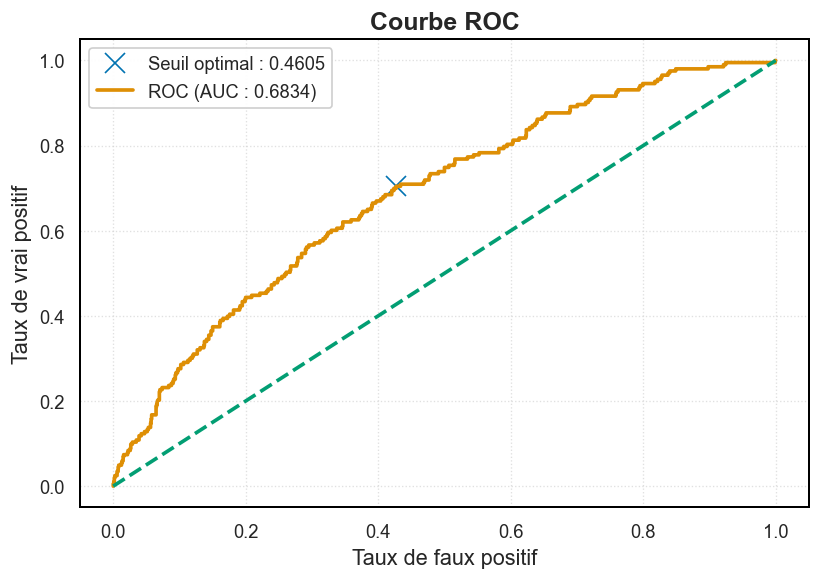

In [125]:
plt.figure(figsize=(7, 5))

plt.plot(
    fpr[optimal_idx],
    tpr[optimal_idx],
    "x",
    markersize=12,
    label=f"Seuil optimal : {optimal_threshold:.4f}",
)

plt.plot(fpr, tpr, label=f"ROC (AUC : {auc:.4f})")
plt.plot([0, 1], [0, 1], "--")

plt.title("Courbe ROC")
plt.xlabel("Taux de faux positif")
plt.ylabel("Taux de vrai positif")
plt.legend()

plt.tight_layout()
plt.show()